# RUL Prediction / Estimation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline

In [2]:
# Create the blank dataframe
combined_data = pd.DataFrame()

# Set the file directory
data_dir = 'D:/Springboard/Capstone_Works/Project/Proj_DataSet/2nd_test'

In [3]:
# Iterate through all the files
for file_name in os.listdir(data_dir):
    df = pd.read_csv(os.path.join(data_dir, file_name), sep='\t')
    # To convert into numpy values
    df_b1 = df.iloc[:,0].values

    # To calculate the mean
    df_b1_mean = np.mean(np.absolute(df_b1))
    
    # To calculate RMS
    df_b1_rms = np.sqrt((np.sum(df_b1**2))/len(df_b1))
    
    # To calculate kurtosis
    df_b1_kurt = scipy.stats.kurtosis(df_b1,fisher=False)
    
    # Concate into Pandas DataFrame
    df_1 = pd.concat([pd.Series(df_b1_mean),pd.Series(df_b1_rms),pd.Series(df_b1_kurt)],axis=1)
    df_1.index = [file_name]
    
    # Append individual dataframes to create a single combined dataset
    combined_data = combined_data.append(df_1)
    
# Insert Column headers    
combined_data.columns = ['Bearing1_Mean','Bearing1_RMS','Bearing1_Kurt']

In [4]:
combined_data

,Bearing1_Mean,Bearing1_RMS,Bearing1_Kurt
2004.02.12.10.32.39,0.058333,0.074180,3.628672
2004.02.12.10.42.39,0.058995,0.075382,3.648479
2004.02.12.10.52.39,0.060236,0.076228,3.513839
2004.02.12.11.02.39,0.061455,0.078726,4.157776
2004.02.12.11.12.39,0.061361,0.078475,3.603207
...,...,...,...
2004.02.19.05.42.39,0.453335,0.725019,15.576977
2004.02.19.05.52.39,0.337583,0.462021,6.759714
2004.02.19.06.02.39,0.351111,0.483847,7.891370
2004.02.19.06.12.39,0.001857,0.002103,6.637219


In [5]:
# Set the data_time index and ensuring the proper format
combined_data.index = pd.to_datetime(combined_data.index, format='%Y.%m.%d.%H.%M.%S')

# Sort the index in chronological order
combined_data = combined_data.sort_index()

# Drop last 2 rows
combined_data = combined_data[:-2]

In [6]:
new_comb_data = combined_data.copy()
new_comb_data = new_comb_data.reset_index()
new_comb_data.columns = ['date_time','Bearing1_Mean','Bearing1_RMS','Bearing1_Kurt']

In [7]:
new_comb_data

,date_time,Bearing1_Mean,Bearing1_RMS,Bearing1_Kurt
0,2004-02-12 10:32:39,0.058333,0.074180,3.628672
1,2004-02-12 10:42:39,0.058995,0.075382,3.648479
2,2004-02-12 10:52:39,0.060236,0.076228,3.513839
3,2004-02-12 11:02:39,0.061455,0.078726,4.157776
4,2004-02-12 11:12:39,0.061361,0.078475,3.603207
...,...,...,...,...
977,2004-02-19 05:22:39,0.338265,0.445929,4.624054
978,2004-02-19 05:32:39,0.301344,0.386944,3.469297
979,2004-02-19 05:42:39,0.453335,0.725019,15.576977
980,2004-02-19 05:52:39,0.337583,0.462021,6.759714


## Calculate the Remaining Useful Life (RUL) interms of Fraction Failing
### Ex: If Fraction Failing = 10%, then RUL is 90%

In [8]:
samples = new_comb_data.Bearing1_RMS[:450]
sample_mean = samples.mean() 
samples_full = new_comb_data.Bearing1_RMS.values
# ffr - feature used to calculate the Fraction Failing
ffr = np.abs(samples_full - sample_mean)

## Fit Weibull Distribution in ffr to get Shape Parameter (alpha) & Scale Parameter (beta)

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error  Lower CI  Upper CI
Parameter                                                    
Alpha            0.013472        0.000957  0.011721  0.015484
Beta             0.475861        0.011763  0.453356  0.499483
Log-Likelihood: 3111.731798423612 



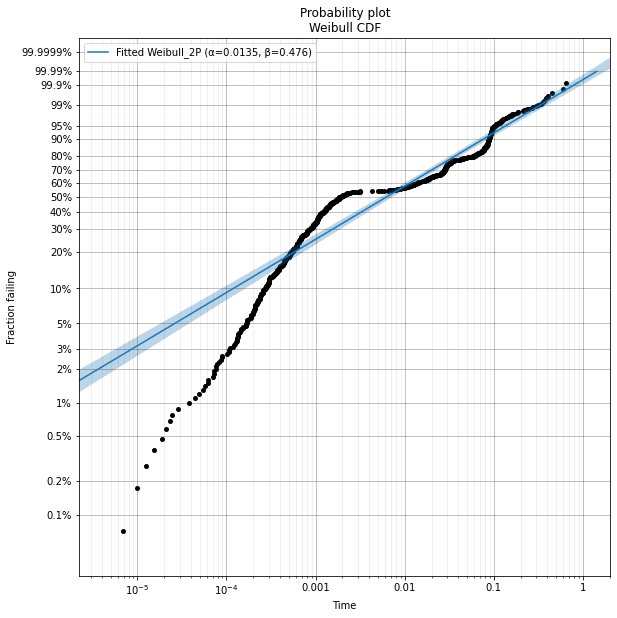

In [9]:
from reliability.Fitters import Fit_Weibull_2P
wb = Fit_Weibull_2P(failures=ffr)

(0.0, 0.6)

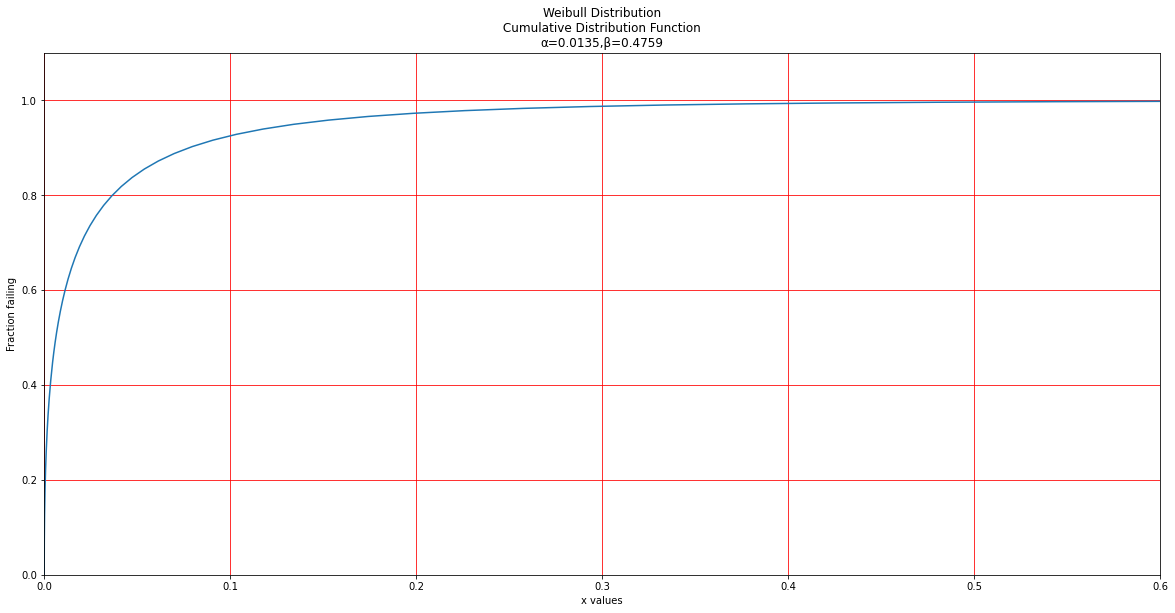

In [10]:
from reliability.Distributions import Weibull_Distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
dist = Weibull_Distribution(alpha=0.0135, beta=0.475861)  # this created the distribution object
dist.CDF()
plt.grid(b=True, which='both',color='r')
plt.xlim(0.0,0.6)

In [11]:
rul_pred = new_comb_data[['date_time','Bearing1_RMS','Bearing1_Kurt']]
# Add ffr feature to dataframe
rul_pred['RMS_Feature'] = ffr

In [12]:
rul_pred

,date_time,Bearing1_RMS,Bearing1_Kurt,RMS_Feature
0,2004-02-12 10:32:39,0.074180,3.628672,0.003013
1,2004-02-12 10:42:39,0.075382,3.648479,0.001812
2,2004-02-12 10:52:39,0.076228,3.513839,0.000966
3,2004-02-12 11:02:39,0.078726,4.157776,0.001532
4,2004-02-12 11:12:39,0.078475,3.603207,0.001281
...,...,...,...,...
977,2004-02-19 05:22:39,0.445929,4.624054,0.368736
978,2004-02-19 05:32:39,0.386944,3.469297,0.309751
979,2004-02-19 05:42:39,0.725019,15.576977,0.647825
980,2004-02-19 05:52:39,0.462021,6.759714,0.384828


## We are creating 5 output classes based on RMS_Feature fitted on Weibull Distribution
Class | RMS_Feature (Range) | Fraction Failing | RUL
------|---------------------|------------------|----
1 | 0.0-0.001 | 0-20% | 80%
2 | 0.001-0.0035 | 20-40% | 60%
3 | 0.0035-0.011 | 40-60% | 40%
4 | 0.011-0.037 | 60-80% | 20%
5 | > 0.037 | 80-100% | < 20%

In [13]:
# Create funtion to find the corresponding class from RMS_Feature
def rul_class(x):
    if x < 0.001:
        return 1
    elif ((x>0.001) & (x<0.0035)):
        return 2
    elif ((x>0.0035) & (x<0.011)):
        return 3
    elif ((x>0.011) & (x<0.037)):
        return 4
    else:
        return 5

rul_pred['Class'] = rul_pred.RMS_Feature.apply(rul_class)

In [14]:
rul_pred

,date_time,Bearing1_RMS,Bearing1_Kurt,RMS_Feature,Class
0,2004-02-12 10:32:39,0.074180,3.628672,0.003013,2
1,2004-02-12 10:42:39,0.075382,3.648479,0.001812,2
2,2004-02-12 10:52:39,0.076228,3.513839,0.000966,1
3,2004-02-12 11:02:39,0.078726,4.157776,0.001532,2
4,2004-02-12 11:12:39,0.078475,3.603207,0.001281,2
...,...,...,...,...,...
977,2004-02-19 05:22:39,0.445929,4.624054,0.368736,5
978,2004-02-19 05:32:39,0.386944,3.469297,0.309751,5
979,2004-02-19 05:42:39,0.725019,15.576977,0.647825,5
980,2004-02-19 05:52:39,0.462021,6.759714,0.384828,5


### To Create a Dataframe with Features (Bearing1_RMS, Bearing1_kurt) Current and Previous Value

In [15]:
rul_pred_df = rul_pred.copy()
rul_pred_df = rul_pred_df.drop(['RMS_Feature'],axis=1)
rul_pred_df['Bearing1_RMS_Prev'] = rul_pred_df['Bearing1_RMS'].shift(1)
rul_pred_df['Bearing1_Kurt_Prev'] = rul_pred_df['Bearing1_Kurt'].shift(1)
rul_pred_df.dropna(inplace=True)

In [16]:
rul_pred_df

,date_time,Bearing1_RMS,Bearing1_Kurt,Class,Bearing1_RMS_Prev,Bearing1_Kurt_Prev
1,2004-02-12 10:42:39,0.075382,3.648479,2,0.074180,3.628672
2,2004-02-12 10:52:39,0.076228,3.513839,1,0.075382,3.648479
3,2004-02-12 11:02:39,0.078726,4.157776,2,0.076228,3.513839
4,2004-02-12 11:12:39,0.078475,3.603207,2,0.078726,4.157776
5,2004-02-12 11:22:39,0.078311,3.456488,2,0.078475,3.603207
...,...,...,...,...,...,...
977,2004-02-19 05:22:39,0.445929,4.624054,5,0.530969,12.795843
978,2004-02-19 05:32:39,0.386944,3.469297,5,0.445929,4.624054
979,2004-02-19 05:42:39,0.725019,15.576977,5,0.386944,3.469297
980,2004-02-19 05:52:39,0.462021,6.759714,5,0.725019,15.576977


The above dataframe is used to predict the RUL class. Now the Remaining Useful Life Estimation is a classification problem, with each class representing a Certain range of failing function (RUL)

<AxesSubplot:xlabel='date_time', ylabel='Bearing1_RMS'>

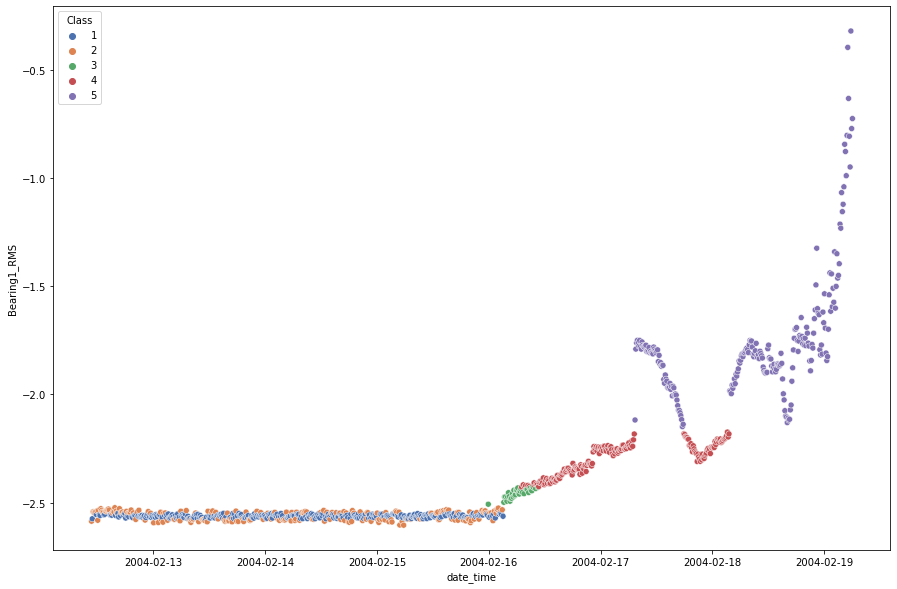

In [17]:
# Save dataframe as CSV file
# rul_pred_df.to_csv("RUL_Dataset.csv")
plt.figure(figsize=(15,10))
sns.scatterplot(x=rul_pred_df.date_time,y=np.log(rul_pred_df.Bearing1_RMS),hue=rul_pred_df.Class,palette='deep')

## Frequency of different RUL Classes 

In [18]:
rul_pred_df.Class.value_counts()

1    328
5    222
2    202
4    194
3     35
Name: Class, dtype: int64

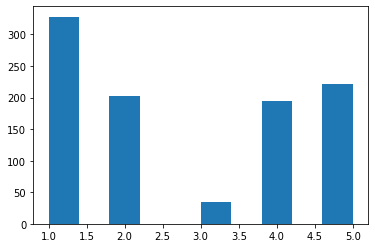

In [19]:
plt.hist(rul_pred_df.Class);

In [20]:
# Train test split
from sklearn.model_selection import train_test_split
X = rul_pred_df.drop(['date_time','Class'],axis=1)
y = rul_pred_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
y_train.value_counts()

1    225
5    153
2    143
4    137
3     28
Name: Class, dtype: int64

In [22]:
y_test.value_counts()

1    103
5     69
2     59
4     57
3      7
Name: Class, dtype: int64

## k-NN Neighbors

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf_knn = KNeighborsClassifier()
params = {"n_neighbors":[2,3,4,5,6,7]}
gcv_knn = GridSearchCV(clf_knn,params,cv=10)
gcv_knn.fit(X_train,y_train)
gcv_knn.best_estimator_

KNeighborsClassifier(n_neighbors=4)

In [24]:
clf_knn_1 = KNeighborsClassifier(n_neighbors=4)
clf_knn_1.fit(X_train,y_train)
y_pred_knn = clf_knn_1.predict(X_test)
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           1       0.59      0.80      0.67       103
           2       0.19      0.10      0.13        59
           3       0.33      0.14      0.20         7
           4       0.79      0.77      0.78        57
           5       0.95      0.88      0.92        69

    accuracy                           0.66       295
   macro avg       0.57      0.54      0.54       295
weighted avg       0.62      0.66      0.63       295



## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
clf_dt = DecisionTreeClassifier(random_state=0)
params = {"max_depth":[2,3,4,5,10]}
gcv_dt = GridSearchCV(clf_dt,params,cv=10)
gcv_dt.fit(X_train,y_train)
gcv_dt.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=0)

In [26]:
clf_dt_1 = DecisionTreeClassifier(max_depth=3,random_state=0)
clf_dt_1.fit(X_train,y_train)
y_pred_dt = clf_dt_1.predict(X_test)
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       103
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        69

    accuracy                           1.00       295
   macro avg       1.00      1.00      1.00       295
weighted avg       1.00      1.00      1.00       295



### Decision Tree Classifier Performs well